<p style="color:red">!!! FILTER (contains(str(?s), "mibact")) da aggiungere sotto la prima tripla</p>

The **CIS (Cultural Institute/Site and Cultural Event) ontology** aims at modelling the data on cultural institutes or sites such as data regarding the agents that play a specific role on cultural institutes or sites, the sites themselves, the contact points, all multimedia files which describe the cultural institute or site and any other information useful to the public in order to access the institute or site.

We specificially employed it to extract all the cultural events present in the dataset through the property **cis:CulturalEvent**

**cis:CulturalEvent** represents an event that typically is related to the cultural domain

In [7]:
import sparql_dataframe

from SPARQLWrapper import SPARQLWrapper, JSON
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

endpoint = 'https://dati.cultura.gov.it/sparql'

query_events = """
PREFIX cis: <http://dati.beniculturali.it/cis/>
PREFIX arco: <https://w3id.org/arco/ontology/arco/>
PREFIX clvapit:<https://w3id.org/italia/onto/CLV/>

SELECT DISTINCT ?s  WHERE {
 ?s a cis:CulturalEvent.
 }
"""

In [8]:
df = sparql_dataframe.get(endpoint, query_events)

We procede getting the cultural events' names, through using the property, **rdfs:label**. We also kept the IRI in order to have a unique identifier both for institutes and sites that will help us to merge our tables.

In [9]:
import sparql_dataframe

from SPARQLWrapper import SPARQLWrapper, JSON
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

endpoint = 'https://dati.cultura.gov.it/sparql'

query_event_label = """
PREFIX cis: <http://dati.beniculturali.it/cis/>
PREFIX arco: <https://w3id.org/arco/ontology/arco/>
PREFIX clvapit:<https://w3id.org/italia/onto/CLV/>

SELECT DISTINCT ?s ?event ?o ?site ?urlcity ?city WHERE {
 ?s a cis:CulturalEvent;
rdfs:label ?event.
}
"""

In [10]:
df = sparql_dataframe.get(endpoint, query_event_label)

We then employed the property **cis:isHostedBySite** to extract all the sites in which the events were held as this specific property links the Event to the Site of the Cultural Institute or Site.

Also in this case we actually extracted both the IRIs and the label through the same property as the one mentioned above.

In [11]:
import sparql_dataframe

from SPARQLWrapper import SPARQLWrapper, JSON
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

endpoint = 'https://dati.cultura.gov.it/sparql'

query_site= """
PREFIX cis: <http://dati.beniculturali.it/cis/>
PREFIX arco: <https://w3id.org/arco/ontology/arco/>
PREFIX clvapit:<https://w3id.org/italia/onto/CLV/>

SELECT DISTINCT ?s ?event ?o ?site ?urlcity ?city WHERE {
 ?s a cis:CulturalEvent;
rdfs:label ?event.
?s cis:isHostedBySite ?o.
?o rdfs:label ?site.
}
"""

In [12]:
df = sparql_dataframe.get(endpoint, query_site)

Then we examined various ways to retrieve the city of each city, examing the various predicates associated to them; the most appropriate and helpful way for us was to first extract the address through **cis:siteAddress** and then from here to get the city through the employment of another ontology (Address (Location) Ontology) and its property **clavpit:hasCity**.

In [13]:
import sparql_dataframe

from SPARQLWrapper import SPARQLWrapper, JSON
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

endpoint = 'https://dati.cultura.gov.it/sparql'

query_culture_events = """
PREFIX cis: <http://dati.beniculturali.it/cis/>
PREFIX arco: <https://w3id.org/arco/ontology/arco/>
PREFIX clvapit:<https://w3id.org/italia/onto/CLV/>

SELECT DISTINCT ?s ?event ?o ?site ?urlcity ?city WHERE {
 ?s a cis:CulturalEvent;
rdfs:label ?event.
?s cis:isHostedBySite ?o.
?o rdfs:label ?site.
?o cis:siteAddress ?address.
?address clvapit:hasCity ?urlcity.
?urlcity rdfs:label ?city
}
"""

In [14]:
df = sparql_dataframe.get(endpoint, query_culture_events)

To further clear up this file from any duplicates that might appear we used the pandas method **drop_duplicates** in order to obtain a clearer table of all the data that we obtained together.

In [15]:
df=df.drop_duplicates(["s", "o"])

Finally we saved all of this data in a csv file to then reuse it for our own graph.

In [16]:
df.to_csv("cleancefile.csv")

Then we worked onto counting first the events per sites

In [2]:
import sparql_dataframe

from SPARQLWrapper import SPARQLWrapper, JSON
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

endpoint = 'https://dati.cultura.gov.it/sparql'

query_site = """
PREFIX cis: <http://dati.beniculturali.it/cis/>
PREFIX arco: <https://w3id.org/arco/ontology/arco/>
PREFIX clvapit:<https://w3id.org/italia/onto/CLV/>

SELECT DISTINCT (count (?o) as ?count) ?site WHERE {
 ?s a cis:CulturalEvent;
rdfs:label ?event.
?s cis:isHostedBySite ?o.
?o rdfs:label ?site.
?o cis:siteAddress ?address.
?address clvapit:hasCity ?urlcity.
?urlcity rdfs:label ?city
}
"""

In [3]:
df_count_sites = sparql_dataframe.get(endpoint, query_site)

In [4]:
df_count_sites.to_csv("numbersite.csv")

Then the events per city.

In [10]:
import sparql_dataframe

from SPARQLWrapper import SPARQLWrapper, JSON
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

endpoint = 'https://dati.cultura.gov.it/sparql'

query_city = """
PREFIX cis: <http://dati.beniculturali.it/cis/>
PREFIX arco: <https://w3id.org/arco/ontology/arco/>
PREFIX clvapit:<https://w3id.org/italia/onto/CLV/>

SELECT DISTINCT (count (?s) as ?count) ?city WHERE {
 ?s a cis:CulturalEvent;
rdfs:label ?event.
?s cis:isHostedBySite ?o.
?o rdfs:label ?site.
?o cis:siteAddress ?address.
?address clvapit:hasCity ?urlcity.
?urlcity rdfs:label ?city
}
"""

In [12]:
df = sparql_dataframe.get(endpoint, query_city)

In [13]:
df.to_csv("numbercity.csv")

In [15]:
endpoint = 'https://dati.cultura.gov.it/sparql'

query = '''
SELECT DISTINCT(?urlcity2) ?dbCity WHERE {
 ?s a cis:CulturalEvent;
rdfs:label ?event.
?s cis:isHostedBySite ?o.
?o rdfs:label ?site.
?o cis:siteAddress ?address.
?address clvapit:hasCity ?urlcity.
?urlcity owl:sameAs ?urlcity2.
?urlcity2 owl:sameAs ?dbCity. 
FILTER(contains (str(?dbCity), "dbpedia") )
}
'''

In [16]:
df = sparql_dataframe.get(endpoint, query)

In [17]:
df

,urlcity2,dbCity
0,http://dati.beniculturali.it/mibact/luoghi/res...,http://dbpedia.org/resource/Besenello
1,http://dati.beniculturali.it/mibact/luoghi/res...,http://dbpedia.org/resource/Calci
2,http://dati.beniculturali.it/mibact/luoghi/res...,http://dbpedia.org/resource/Carmignano
3,http://dati.beniculturali.it/mibact/luoghi/res...,http://dbpedia.org/resource/Cetona
4,http://dati.beniculturali.it/mibact/luoghi/res...,http://dbpedia.org/resource/Chiusi
...,...,...
789,http://dati.beniculturali.it/mibact/luoghi/res...,http://dbpedia.org/resource/Casalciprano
790,http://dati.beniculturali.it/mibact/luoghi/res...,http://dbpedia.org/resource/Monterosso_Grana
791,http://dati.beniculturali.it/mibact/luoghi/res...,http://dbpedia.org/resource/Castrocielo
792,http://dati.beniculturali.it/mibact/luoghi/res...,http://dbpedia.org/resource/Lu_e_Cuccaro_Monfe...


In [ ]:
from sparql_dataframe import get
endpoint = 'https://dati.cultura.gov.it/sparql'

#count of all the cities
query = '''
SELECT COUNT(DISTINCT(?urlcity) as ?count) WHERE {
 ?s a cis:CulturalEvent;
rdfs:label ?event.
?s cis:isHostedBySite ?o.
?o rdfs:label ?site.
?o cis:siteAddress ?address.
?address clvapit:hasCity ?urlcity.
}
'''
CountCity = get(endpoint, query)
CountCity

After having extracted all the geographical information, we then moved onto working into the temporal one.

We did this through the employment of the **Time ontology** (Italian application profile) in the properties tiapit:atTime.

This actually gave us a time interval composed by a **start time** and **end time**, which were then explicited through the xsd format with the properties **tiapit:startTime** and **tiapit:endTime**.

In [18]:
import sparql_dataframe

from SPARQLWrapper import SPARQLWrapper, JSON
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

endpoint = 'https://dati.cultura.gov.it/sparql'

query_time="""SELECT DISTINCT ?s ?time ?starttime ?endtime WHERE {
 ?s a cis:CulturalEvent;
rdfs:label ?event.
?s tiapit:atTime ?time.
?time tiapit:startTime ?starttime;
tiapit:endTime ?endtime.
}"""

In [19]:
df = sparql_dataframe.get(endpoint, query_time)

Everything was saved in a csv file.

In [8]:
df.to_csv("time.csv")

Similarly as we had done with the geographical information we counted how many events per start time (as we took it as standard for the time).

In [20]:
query_count_time ="""SELECT DISTINCT (count (?s) as ?count) ?starttime WHERE {
 ?s a cis:CulturalEvent;
rdfs:label ?event.
?s tiapit:atTime ?time.
?time tiapit:startTime ?starttime;
tiapit:endTime ?endtime.
?s cis:isHostedBySite ?o.
?o rdfs:label ?site.
?o cis:siteAddress ?address.
?address clvapit:hasCity ?urlcity.
}"""

In [21]:
df = sparql_dataframe.get(endpoint, query_count_time)

As always it was saved in a csv file.

In [12]:
df.to_csv("time_count.csv")

In [10]:
# pandas
import pandas as pd

# parse the csv into a dataframe
df = pd.read_csv("numbersite.csv")
df = df[["count","site"]]
df.head


<bound method NDFrame.head of       count                                               site
0         4  Sede di Soprintendenza Archeologia, Belle Arti...
1         6                   Sede di Teatro Romano di Trieste
2         7  Sede di Museo archeologico nazionale  di Volce...
3        10       Sede di Direzione Regionale Musei Basilicata
4         4        Sede di Istituto Centrale per l'Archeologia
...     ...                                                ...
1463      2             Sede di Raccolta d'arte Carlo Lamberti
1464      1    Sede di Museo Vallivo Valfurva Mario Testorelli
1465      1  Sede di Museo universitario d'Abruzzo - Museo ...
1466      2  Sede di Musei civici d'arte antica - Collezion...
1467      5       Sede di Museo Archeologico di Sala Consilina

[1468 rows x 2 columns]>

In [11]:
import pandas_profiling as pp
pp.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

[Text(0, 0, 'Sede di Soprintendenza Archeologia, Belle Arti e Paesaggio per il Molise'),
 Text(1, 0, 'Sede di Teatro Romano di Trieste'),
 Text(2, 0, 'Sede di Museo archeologico nazionale  di Volcei "Marcello Gigante" di Buccino'),
 Text(3, 0, 'Sede di Direzione Regionale Musei Basilicata'),
 Text(4, 0, "Sede di Istituto Centrale per l'Archeologia"),
 Text(5, 0, 'Sede di Museo civico pinacoteca "Palazzo Lazzarini"'),
 Text(6, 0, 'Sede di Archivio di Stato di Latina'),
 Text(7, 0, "Sede di Museo Nori de' Nobili"),
 Text(8, 0, 'Sede di Biblioteca Antonelliana'),
 Text(9, 0, 'Sede di Museo di storia della mezzadria "Sergio Anselmi"'),
 Text(10, 0, 'Sede di Fondazione Arca, Biblioteca'),
 Text(11, 0, 'Sede di Parco archeologico di Grumentum'),
 Text(12, 0, 'Sede di Biblioteca La Fornace'),
 Text(13, 0, 'Sede di Palazzo Arese-Litta'),
 Text(14, 0, 'Sede di Archivio di Stato di Potenza'),
 Text(15, 0, 'Sede di Istituto Centrale per il patrimonio immateriale'),
 Text(16, 0, 'Sede di Palazzo N

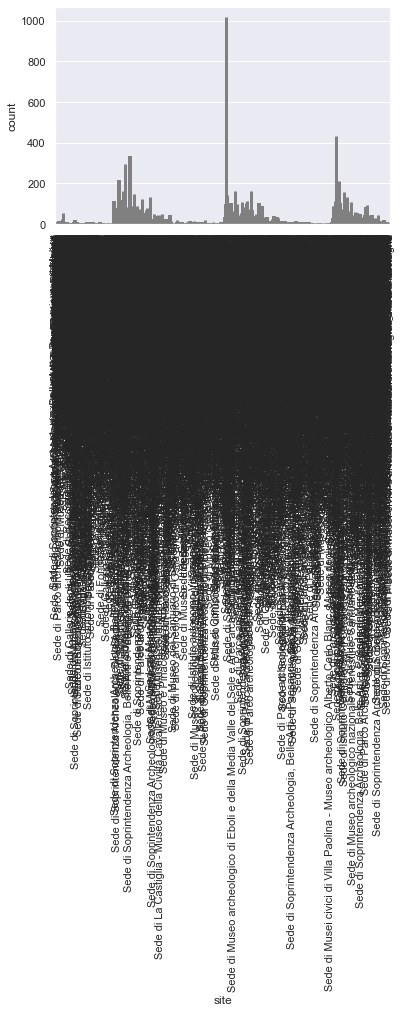

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Apply the default theme
# sns.set_theme() in older versions of seaborn
sns.set()

# rename data frame
periods = df

# count function to show the number of observations of a category (period_label) in a dataset as a bar chart
# see documentation here https://seaborn.pydata.org/generated/seaborn.catplot.html
my_plot=sns.barplot(
    data=df, x="site", y="count",
    errorbar=("pi", 50), capsize=.4, errcolor=".5",
    linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0),
)

my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=90)